# Legumes Recognition Demo

This notebook demonstrates the complete workflow for:
1. Feature extraction from seed images
2. Training an SVM classifier
3. Detecting and classifying seeds in test images

In [1]:
import numpy as np
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
import os
import joblib
from feature_extraction import extract_feature, compute_crop_and_keypoints
from tqdm.auto import tqdm
%matplotlib inline

## 1. Feature Extraction

Extract features from all images in the dataset

In [2]:
# Initialize DataFrame
df = pd.DataFrame(columns=['label','area', 'perimeter', 'aspect_ratio', 'circularity', 
                          'mean_color_b', 'mean_color_g', 'mean_color_r'])

PATH = 'SIV_dataset/'
subdirectories = [d for d in os.listdir(PATH) if os.path.isdir(os.path.join(PATH, d)) and d != 'Test']

for subdir in tqdm(subdirectories, desc='Processing Folders'):
    images = [img for img in os.listdir(os.path.join(PATH, subdir)) if img.endswith('.jpg')]
    
    for filename in tqdm(images, desc=f'Processing {subdir}', leave=False):
        file_path = os.path.join(PATH, subdir, filename)
        img = cv.imread(file_path)
        img = cv.resize(img, (500, 500))
        
        crop, keypoint_features = compute_crop_and_keypoints(img)
        contour_features = extract_feature(crop)
        
        # Combine features
        features = {**keypoint_features, **contour_features}
        features = {k: round(v, 2) for k, v in features.items()}
        
        # Add to DataFrame
        new_row = {'label': subdir, **features}
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

df.to_csv('features.csv', index=False)
print("Features extracted and saved to features.csv")
df.head()

Processing Folders:   0%|          | 0/5 [00:00<?, ?it/s]

Processing Avena:   0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_61015/1692588690.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)


Processing Orzo:   0%|          | 0/20 [00:00<?, ?it/s]

Processing Lenticchia:   0%|          | 0/20 [00:00<?, ?it/s]

Processing fagiolo:   0%|          | 0/20 [00:00<?, ?it/s]

Processing Ceci :   0%|          | 0/20 [00:00<?, ?it/s]

Features extracted and saved to features.csv


,label,area,perimeter,aspect_ratio,circularity,mean_color_b,mean_color_g,mean_color_r,num_keypoints,avg_keypoint_size,descriptor_mean,descriptor_std
0,Avena,539.5,96.18,1.20,0.73,103.79,131.53,148.57,5.0,3.35,26.799999,36.459999
1,Avena,113.0,432.42,1.23,0.01,117.04,137.54,152.95,11.0,4.78,25.940001,37.049999
2,Avena,169.5,61.70,1.77,0.56,122.00,142.64,156.18,3.0,3.73,22.980000,38.950001
3,Avena,662.0,98.08,0.91,0.86,114.36,138.76,155.71,2.0,3.65,26.120001,37.009998
4,Avena,20.0,231.97,1.50,0.00,129.06,144.15,156.28,2.0,5.46,23.510000,38.650002


## 2. Train SVM Model

Model accuracy: 0.80


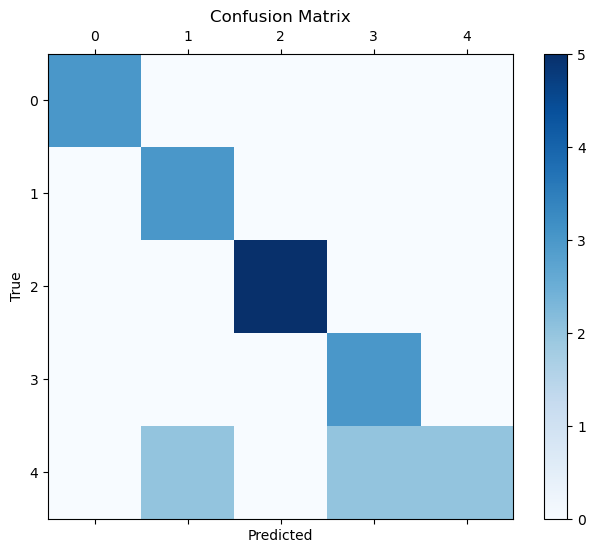

In [ ]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import random
import joblib
# Load features
df = pd.read_csv('features.csv')
feature_vectors = df.drop('label', axis=1).values
labels = df['label'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    feature_vectors, labels, test_size=0.2, random_state=random.randint(0, 1000)
)

# Train SVM
svm = make_pipeline(StandardScaler(), SVC(kernel='linear', C=2.5))
svm.fit(X_train, y_train)

# Save model
joblib.dump(svm, 'svm_model.pkl')

# Evaluate
accuracy = svm.score(X_test, y_test)
print(f'Model accuracy: {accuracy:.2f}')

# Plot confusion matrix
y_pred = svm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.matshow(cm, fignum=1, cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## 3. Test on New Images

In [ ]:
from main import compute_informations

# Load test images
TEST_FOLDER = 'SIV_dataset/Test'
test_files = os.listdir(TEST_FOLDER)
max_area = df['area'].max()
min_area = df['area'].min()*3
# Process each test image
for file in test_files:
    img = cv.imread(os.path.join(TEST_FOLDER, file))
    img = cv.resize(img, (500, 500))
    img = img[20:-20, 20:-20]  # Crop borders
    
    # Detect and classify seeds
    result_img, counts = compute_informations(img.copy(),min_area=min_area,max_area=max_area,svm=svm,df=df)
    
    # Display results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    ax2.imshow(cv.cvtColor(result_img, cv.COLOR_BGR2RGB))
    ax2.set_title('Detected Seeds')
    ax2.axis('off')
    
    plt.figure(figsize=(8, 4))
    plt.bar(counts.keys(), counts.values())
    plt.title('Seed Distribution')
    plt.show()

NameError: name 'df' is not defined